In [1]:
import io, math
import pandas as pd
import numpy as np
from transitions.extensions import GraphMachine
from IPython.display import Image, display

# Теория автоматов

Исследование процесса перевода абстрактного (*АА*) автомата в автомат
структурный (*СА*). Задача создания *СА* сводится к вычислению функций
выходных сигналов $y_n$ и функций сигналов возбуждения элементов памяти $U_r$.
Все сигналы исходят из комбинационной схемы *КС*. Сигналов возбуждения
элементов памяти связывает *КС* и память *П*.
Документ основан на [учебном пособии][1] Ожиганова А. А. "Теория автоматов".

План документа:

1. Общая теория
2. Описание *АА* Мили с помощью таблиц переходов
3. Реализация модели автомата с помощью библиотеки [transitions][2]
4. Запуск *АА* на заданном входном слове
6. Преобразование *АА* в *СА*  с помощью библиотеки [pyeda][3]
    1. Кодирование входных и выходных сигналов *разрядным* двоичным кодом
    2. Кодировка состояний [кодом Грея][4]
    3. Нахождение функций выходных сигналов $y_n$ и $U_r$
8. Запуск *СА* на входном слове заданном для *АА*
9. Проверка равенства двух выходных слов

Для удобства входной и выходной алфавиты обоих автоматов кодированы рядом
натуральных чисел $\mathbb{N}$. При этом при создании автоматов их алфавиты
могут быть вполне разнообразными. При кодировке состояний используется код
Грея для минимизации действий необходимых для смены состояния.


[1]: https://books.ifmo.ru/book/826/teoriya_avtomatov._uchebnoe_posobie.htm
[2]: https://github.com/pytransitions/transitions
[3]: https://pyeda.readthedocs.io/en/latest/index.html
[4]: https://ru.wikipedia.org/wiki/Код_Грея

## Общая теория

Напомним, что любой автомат описывается шестикомпонентным набором:

$S = (A, Z, W, \delta, \lambda, a1)$, где

1. $A = {a_1,...,a_m,...,a_M}$ - множество состояний или алфавит состояний *АА*
2. $Z = {z_1,...,z_f,...,z_F}$ - множество входных сигналов или входной алфавит *АА*
3. $W = {w_1,...,w_g,...,w_G}$ - множество выходных сигналов или выходной алфавит *АА*
4. $\delta$ - функция переходов *АА*: $\delta(a_m, z_f) \mapsto a_s\ |\ a_m, a_s \in A$
5. $\lambda$ - функция выходов *АА*: $\lambda(a_m, z_f) \mapsto w_g\ |\ a_m \in A, w_g \in G$
7. $а_1$ - начальное состояние *АА*

## Описание АА

Задаём алфавиты состояний, сигналов, функции $\delta$ и $\lambda$ и начальное состояние.

In [2]:
states = ['a1', 'a2', 'a3'] # A
events = ['z1', 'z2', 'z3'] # Z
initial = 'a1'              # a1

In [3]:
delta = np.array(           # delta
    [['a2', '', 'a1'],
     ['a3', 'a1', ''],
     ['a2', 'a3', 'a3']])
lmbda = np.array(           # lambda
    [['w1', '', 'w2'],
     ['w4', 'w5', ''],
     ['w2', 'w1', 'w3']])

In [4]:
deltaFr = pd.DataFrame(
    delta,
    columns=states,
    index=events)
deltaFr

,a1,a2,a3
z1,a2,,a1
z2,a3,a1,
z3,a2,a3,a3


In [5]:
lmbdaFr = pd.DataFrame(
    lmbda,
    columns=states,
    index=events)
lmbdaFr

,a1,a2,a3
z1,w1,,w2
z2,w4,w5,
z3,w2,w1,w3


## Реализация модели автомата

In [6]:
class Automat():    
    def __init__(self):
        self.inputDict = {}  # Z
        self.outputDict = {} # W
        self.input = []
        self.output = []
        # Для удобства логика конструктора вынесена вовне

    def process(self):
        self.output = []
        for inpSigNum in model.input:
            inpSigStr = str(inpSigNum)
            inpSig = self.inputDict[inpSigStr]
            event = getattr(self, inpSig)
            event()
    
    def show_graph(self, **kwargs):        
        stream = io.BytesIO()
        self.get_graph(**kwargs).draw(stream, prog='dot', format='png')
        display(Image(stream.getvalue()))

In [7]:
model = Automat()
model.states = states
model.states

['a1', 'a2', 'a3']

In [8]:
machine = GraphMachine(
    model=model,
    states=model.states, 
    initial=initial)

In [9]:
desc = np.dstack((delta, lmbda))
desc.shape

(3, 3, 2)

In [10]:
def decode(model, outSig):
    letter = model.outputDict[outSig]
    model.output.append(letter)

In [11]:
outputDict = {} # W
mappings = []

lastSig = 1
for z in range(desc.shape[0]):
    inpSig = events[z]
    for a in range(desc.shape[1]):
        fromState = states[a]
        toState = desc[z, a, 0]
        outSig = desc[z, a, 1]
        if not toState: continue
        if outSig not in outputDict:
            outputDict[outSig] = lastSig
            lastSig = lastSig + 1
            #setattr(Automat, outSig, lambda self: self.decode(outSig))

        mappings.append([inpSig, fromState, toState, outSig])
        machine.add_transition(
            inpSig,
            fromState,
            toState,
            after = lambda outSig=outSig: decode(model, outSig))

model.outputDict = outputDict
outputDict

{'w1': 1, 'w2': 2, 'w4': 3, 'w5': 4, 'w3': 5}

In [12]:
mappings

[['z1', 'a1', 'a2', 'w1'],
 ['z1', 'a3', 'a1', 'w2'],
 ['z2', 'a1', 'a3', 'w4'],
 ['z2', 'a2', 'a1', 'w5'],
 ['z3', 'a1', 'a2', 'w2'],
 ['z3', 'a2', 'a3', 'w1'],
 ['z3', 'a3', 'a3', 'w3']]

In [13]:
inputDict = {}  # Z
for z in range(desc.shape[0]):
    num = str(z + 1)
    sig = events[z]
    inputDict[num] = sig

model.inputDict = inputDict
inputDict

{'1': 'z1', '2': 'z2', '3': 'z3'}

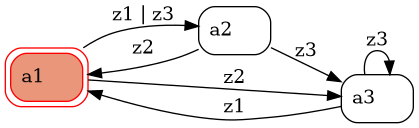

In [14]:
model.show_graph()

In [15]:
model.z2()
model.state

'a3'

In [16]:
model.z1()
model.state

'a1'

## Запуск АА на заданном входном слове

In [17]:
model.input = [2, 1, 3, 2, 1, 3, 3, 3, 1]
model.process()
model.state

'a1'

In [18]:
AAIO = np.array([model.input, model.output])
AAIO

array([[2, 1, 3, 2, 1, 3, 3, 3, 1],
       [3, 2, 2, 4, 1, 1, 5, 5, 2]])

## Преобразование АА в СА

### Кодирование входных, выходных сигналов и состояний

Каждому из следующих множеств (компонентов) нашего *АА* ставится в соответствие некий двоичный вектор.

Входные сигналы $Z$:

$$
z_f \mapsto (e_{f1},...,e_{fl},...,e_{fL})\ | \ e_{fl} \in \{0, 1\}, L = \lceil log_2F \rceil
$$

Выходные сигналы $W$:

$$
w_g \mapsto (e_{g1},...,e_{gn},...,e_{gN})\ | \ e_{gn} \in \{0, 1\}, N = \lceil log_2G \rceil
$$

Состояния $A$:

$$
a_m \mapsto (e_{m1},...,e_{mr},...,e_{mR})\ | \ e_{mr} \in \{0, 1\}, R = \lceil log_2M \rceil
$$

Запись $\lceil x \rceil$ означает *потолок* (`ceil`) - ближайшее целое число большее или равно $x$.

Для кодирования входных и выходных сигналов можно использовать обычный *разрядовый* двоичный код:

$$
\begin{array}{c}
    0000\\
    0001\\
    0010\\
    0011\\
    0100\\
    ...
\end{array} 
$$

При *разрядовом* двоичном кодировании соседние значения могут отличаться более чем на бит. К примеру
разница между числом $01_{b}$ и $10_{b}$ два бита - младший и старший. Данная разница описывается термином:
[*расстояние Хэмминга*][1]:

$$
d_{ij} = \sum_{k=1}^{p} |x_{ik}-x_{jk}|
$$

Соответственно при использовании *разрядового* кодирования в физической среде электрических сигналов
растёт риск помех. Так же растёт сложность механизмов участвующих в кодировке и раскодировке этих
сигналов. Несмотря на это предполагается, что *внешняя среда* относительно нашего *СА* достаточно развитая
для такого взаимодействия. Так же возникает необходимость следовать стандартным интерфейсам.
Следовательно входной и выходной алфавиты кодируются именно *разрядным* образом.

Но переход между состояниями во *внутренней среде* нашего автомата лучше всего совершать с помощью
[*кода Грея*][2]. В этом случае соседствующие значения всегда отличаются на один бит:

$$
\begin{array}{c}
    0000\\
    0001\\
    0011\\
    0010\\
    0110\\
    ...
\end{array} 
$$

Для перехода из *разрядного* в *код Грея* используется следующая формула, где $i$ это позиция бита:

$$
G_{i} = B_{i} \oplus B_{i+1}
$$

При каноническом (стандартном) методе структурного синтеза автомат представляют
в виде двух частей: памяти (П) и комбинационной схемы (КС). КС состоит из
логических элементов, а память из автоматов памяти. Элементарными автоматами
памяти являются триггерные схемы.

![ConceptualScheme](img/CS.png "Концептуальная схема")

Задача синтеза автомата сводится к нахождению функций:

$$
U_r = U_r(Q_1,..., Q_R, x_1,..., x_L), r = 1,..., R
$$

$$
y_n = y_n(Q_1,..., Q_R, x_1,..., x_L), n = 1,..., N
$$

[1]: https://ru.wikipedia.org/wiki/Расстояние_Хэмминга
[2]: https://ru.wikipedia.org/wiki/Код_Грея

In [122]:
def calcBinArrLen(x):
    return math.ceil(math.log2(x))

In [123]:
def buildColumns(vectorLen, prefix):
    return [prefix + str(x + 1) for x in range(vectorLen)]

In [124]:
def encodeSignals(abcLength, gray=False):
    vectorLength = calcBinArrLen(abcLength)
    signalsBin = np.zeros(
        [abcLength, vectorLength],
        dtype = np.dtype(bool))
    for i in range(abcLength):
        for n in range(vectorLength):
            inputSignal = i
            if gray:
                inputSignal = inputSignal ^ (inputSignal >> 1)
            bit = inputSignal & (0x1 << (vectorLength - 1 - n))
            bit = True if bit else False
            signalsBin[i][n] = bit
    return signalsBin

In [134]:
alphabets = {
    'Z': list(model.inputDict.values()),
    'W': list(model.outputDict.keys()),
    'A': model.states
}

abcLengths = {
    'Z': len(alphabets['Z']),
    'W': len(alphabets['W']),
    'A': len(alphabets['A'])
}

# Создаём массив закодированных векторов входного и выходного алфавитов, а так же алфавита состояний
vectors = {
    'Z': encodeSignals(abcLengths['Z']),
    'W': encodeSignals(abcLengths['W']),
    'A': encodeSignals(abcLengths['A'], True)
}

vectorLengths = {
    'Z': vectors['Z'].shape[1],
    'W': vectors['W'].shape[1],
    'A': vectors['A'].shape[1]
}

contactNames = {
    'Z': buildColumns(vectorLengths['Z'], 'x'),
    'W': buildColumns(vectorLengths['W'], 'y'),
    'A': buildColumns(vectorLengths['A'], 'Q')
}

In [135]:
pd.DataFrame(
    vectors['Z'],
    columns=contactNames['Z'],
    index=alphabets['Z'])

,x1,x2
z1,False,False
z2,False,True
z3,True,False


In [136]:
pd.DataFrame(
    vectors['W'],
    columns=contactNames['W'],
    index=alphabets['W'])

,y1,y2,y3
w1,False,False,False
w2,False,False,True
w4,False,True,False
w5,False,True,True
w3,True,False,False


In [137]:
pd.DataFrame(
    vectors['A'],
    columns=contactNames['A'],
    index=alphabets['A'])

,Q1,Q2
a1,False,False
a2,False,True
a3,True,True
